In [ ]:
import subprocess
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns

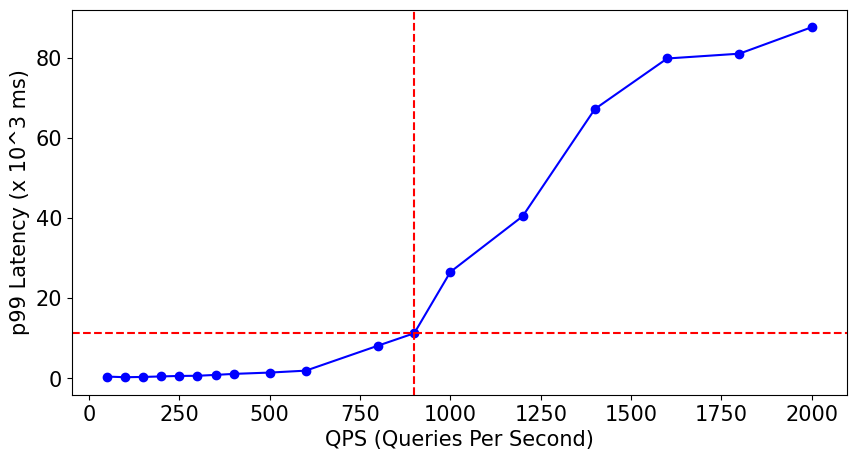

In [27]:
import matplotlib.pyplot as plt

# Updated data provided
QPS_latency = [[50, 0.45], [100, 0.29], [150, 0.36], [200, 0.49], [250, 0.61], [300, 0.65], [350, 0.87], 
               [400, 1.12], [500, 1.45], [600, 1.93], [800, 8.17], [900, 11.26], [1000, 26.55], 
               [1200, 40.44], [1400, 67.2], [1600, 79.8], [1800, 81], [2000, 87.6]]

# Separating the data into X (QPS) and Y (latency in seconds)
X = [x[0] for x in QPS_latency]
Y = [y[1] for y in QPS_latency]  # using the actual latency values in seconds

# Creating the line plot
plt.figure(figsize=(10, 5))
plt.plot(X, Y, marker='o', linestyle='-', color='b')
plt.xlabel('QPS (Queries Per Second)', fontsize=15)
plt.ylabel('p99 Latency (x 10^3 ms)', fontsize=15)  # Updated label to reflect actual latency in seconds
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Highlighting the specific point with grid lines
plt.axvline(x=900, color='red', linestyle='--')  # Vertical line at x = 900
plt.axhline(y=11.26, color='red', linestyle='--')  # Horizontal line at y = 11.26 seconds

plt.grid(False)  # Disable the general grid
plt.show()



In [ ]:


# Function to execute wrk command
def run_wrk(url, script_path, duration, rate, data_dir):
    current_time_str = datetime.now().strftime("%Y%m%d%H%M")
    result_filename = f"{data_dir}/{current_time_str}_{rate}_{duration}.txt"
    command = f"/home/ubuntu/DeathStarBench/wrk2/wrk -D exp -t2 -c100 -d{duration} -L -s {script_path} {url} -R{rate}"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    
    with open(result_filename, 'w') as file:
        file.write(result.stdout)
    
    print(f"Results for rate {rate} saved to {result_filename}")
    return result_filename

# Function to parse wrk output
def parse_wrk_output(filename):
    latencies = []
    recording = False  # Flag to start recording latencies
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("  Detailed Percentile spectrum:"):
                recording = True
                continue
            if line.startswith("#[Mean"):
                break
            if recording:
                parts = line.split()
                if len(parts) >= 2:
                    try:
                        latency = float(parts[0])
                        latencies.append(latency)
                    except ValueError:
                        continue
    return latencies


In [ ]:

data_dir = "/home/ubuntu/ms_scheduling/social_net/perf_testing/data"
os.makedirs(data_dir, exist_ok=True)

url = "http://nginx-thrift.social-network.svc.cluster.local:8080/wrk2-api/home-timeline/read"
script_path = "/home/ubuntu/DeathStarBench/socialNetwork/wrk2/scripts/social-network/read-home-timeline.lua"
duration = "1m"
# request_rates = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550,
#                  600, 650,700,750, 800,850, 900,950, 1000, 1050, 1100, 1150, 
#                  1200, 1250, 1350, 1400, 1450, 1500]

# Use a for loop to generate the above QPS list
request_rates = [i for i in range(100, 1500 + 1, 50)]


result_files = []
latency_data = {}
p99_latencies = []

for rate in tqdm(request_rates, desc="Running wrk for different rates"):
    filename = run_wrk(url, script_path, duration, rate, data_dir)
    latencies = parse_wrk_output(filename)
    latency_data[rate] = latencies
    if latencies:
        # plot_filename = filename.replace('.txt', '_cdf.png')
        # plot_cdf(latencies, plot_filename)
        p99_latencies.append(np.percentile(latencies, 99))  # Calculate and store the p99 latency



In [ ]:

# Plot the p99 latency line plot
if p99_latencies:
    plt.figure(figsize=(10, 6))
    plt.plot(request_rates, [latency / 1000 for latency in p99_latencies], marker='o', linestyle='-', color='red')
    plt.xlabel('Request Rate')
    plt.ylabel('p99 Latency (*1000 ms)')
    plt.title('p99 Latency by Request Rate')
    plt.grid(True)
    
    current_time_str = datetime.now().strftime("%Y%m%d%H%M")
    filename = f"{data_dir}/p99_latency_plot_{current_time_str}.png"
    plt.savefig(filename)
    plt.close()
    print(f"Saved p99 latency plot to {filename}")

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(request_rates, [latency / 1000 for latency in p99_latencies], marker='o', linestyle='-', color='red')
plt.xlabel('Request Rate')
plt.ylabel('p99 Latency (*1000 ms)')
plt.title('p99 Latency by Request Rate')
plt.grid(True)

# current_time_str = datetime.now().strftime("%Y%m%d%H%M")
# filename = f"{data_dir}/p99_latency_plot_{current_time_str}.png"

print(f"Saved p99 latency plot to {filename}")